# Perceptual Task Replication — LLMs as Participants

This notebook replicates the **perceptual detection task** from Juni & Eckstein (2015), but replaces human participants with **LLMs**.

On each trial:

- An LLM "participant" views a noisy image and reports a **confidence rating** on a 1–10 scale:  
  - **1–5** → Signal **ABSENT** (1 = highest confidence absent)  
  - **6–10** → Signal **PRESENT** (10 = highest confidence present)  
- These responses mimic the paper’s 10-point confidence scale.  
- Results are collected for multiple providers (e.g., **OpenAI** and **Gemini**).

---

### Conditions
- **Equal** → All participants see comparable signal strength. Majority rules tend to perform near-optimally.  
- **Mixture** → One participant sees a strong signal, two see weak signals. Majority can be suboptimal; alternative group rules may explain behavior better.

---

### Inputs
- Stimulus images (PNG files) generated in `allimgs/`.  
- Metadata file `trials.csv` containing:  
  - `TrialID`, `Condition` (`equal` or `mixture`), `Truth` (0/1),  
  - `Image` (path to the stimulus).  

---

### Outputs
- A CSV (`llm_results.csv`) containing per-trial responses with confidence, binary predictions, correctness, and latency.  
- Diagnostic plots and summary tables:  
  - Accuracy overall and by condition  
  - Mean confidence for absent vs present trials  
  - Example stimulus previews for quality control  

---

### API Keys
Environment variables (never hard-coded):
- `OPENAI_API_KEY`  
- `GEMINI_API_KEY`


In [31]:
# %%
# !pip install --quiet google-generativeai openai pillow pandas numpy tqdm matplotlib

from __future__ import annotations
import os, base64
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# APIs
import google.generativeai as genai
from openai import OpenAI

# Where the generator put things
TRIALS_CANDIDATES = ["/workspaces/Honors_Project/trials.csv", os.path.join("allimgs", "index.csv")]
RESULTS_CSV = "llm_results.csv"

# Models (override via env if you want)
OPENAI_MODEL  = os.getenv("OPENAI_MODEL",  "gpt-4o-mini")
GEMINI_MODEL  = os.getenv("GEMINI_MODEL",  "gemini-2.0-flash-thinking-exp-01-21")

# Expect env keys in Codespaces/terminal
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

print(f"[cfg] trials={TRIALS_CANDIDATES}")
print(f"[cfg] providers=['OpenAI','Gemini'] models={[OPENAI_MODEL, GEMINI_MODEL]}")


[cfg] trials=['/workspaces/Honors_Project/trials.csv', 'allimgs/index.csv']
[cfg] providers=['OpenAI','Gemini'] models=['gpt-4o-mini', 'gemini-2.0-flash-thinking-exp-01-21']


In [1]:
# %%
from typing import Sequence

def _first_existing(paths: Sequence[str]) -> str:
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("Could not find trials.csv. Run your image generator notebook first.")

def load_trials() -> pd.DataFrame:
    path = _first_existing(TRIALS_CANDIDATES)
    df = pd.read_csv(path) if path.endswith(".csv") else pd.read_excel(path)

    need = {"TrialID","Condition","Truth"}
    if not need.issubset(df.columns):
        raise ValueError(f"Trials file missing required columns {need}. Found {list(df.columns)}")

    # The generator writes one image column ("Image")
    if "Image" not in df.columns:
        raise ValueError("Expected an 'Image' column with PNG paths (from allimgs/).")

    # Normalize types
    df["Condition"] = df["Condition"].astype(str).str.strip().str.lower()
    df["Truth"] = df["Truth"].astype(int)
    return df

df_trials = load_trials()
PROJECT_ROOT = Path("/workspaces/Honors_Project")
df_trials["Image"] = df_trials["Image"].apply(lambda p: str(PROJECT_ROOT / p))
print(f"[data] {len(df_trials)} trials")
display(df_trials.head(3))


NameError: name 'pd' is not defined

In [33]:
# %%
assert OPENAI_API_KEY, "Missing OPENAI_API_KEY env var."
assert GEMINI_API_KEY, "Missing GEMINI_API_KEY env var."

# Clients
openai_client = OpenAI(api_key=OPENAI_API_KEY)
genai.configure(api_key=GEMINI_API_KEY)
gemini = genai.GenerativeModel(GEMINI_MODEL)

SYSTEM_PROMPT = (
    "You are shown a noisy grayscale image that may or may not contain a faint Gaussian luminance blob.\n"
    "Your task is to decide if the blob is present or absent AND indicate your confidence.\n\n"
    "Respond with ONLY a single integer from 1 to 10, with no other text:\n"
    "- 1 = ABSENT, highest confidence\n"
    "- 2–5 = ABSENT, decreasing confidence\n"
    "- 6–9 = PRESENT, increasing confidence\n"
    "- 10 = PRESENT, highest confidence"
)

def encode_image_b64(path: str) -> str:
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def parse_confidence(text: str) -> int:
    """
    Parse model output into an integer 1–10.
    Falls back to -1 if parsing fails.
    """
    try:
        val = int("".join(ch for ch in text if ch.isdigit()))
        if 1 <= val <= 10:
            return val
    except:
        pass
    return -1  # indicates invalid response



In [34]:
# %%
def call_openai(image_path: str, model: str = OPENAI_MODEL) -> dict:
    img_b64 = encode_image_b64(image_path)
    resp = openai_client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": [
                {
                    "type": "text",
                    "text": (
                        "Decide if a faint Gaussian luminance blob is present in this noisy image.\n"
                        "Respond with ONLY a single integer from 1 to 10:\n"
                        "- 1 = ABSENT with highest confidence\n"
                        "- 2–5 = ABSENT with decreasing confidence\n"
                        "- 6–9 = PRESENT with increasing confidence\n"
                        "- 10 = PRESENT with highest confidence"
                    )
                },
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{img_b64}"}}
            ]}
        ],
        max_tokens=5,
        temperature=0
    )
    out = resp.choices[0].message.content or ""
    return {"raw": out, "decision": parse_confidence(out)}


def call_gemini(image_path: str, model_obj=gemini) -> dict:
    img = Image.open(image_path).convert("RGB")
    prompt = (
        SYSTEM_PROMPT + "\n\n"
        "Decide if a faint Gaussian luminance blob is present in this noisy image.\n"
        "Respond with ONLY a single integer from 1 to 10:\n"
        "- 1 = ABSENT with highest confidence\n"
        "- 2–5 = ABSENT with decreasing confidence\n"
        "- 6–9 = PRESENT with increasing confidence\n"
        "- 10 = PRESENT with highest confidence"
    )
    resp = model_obj.generate_content([prompt, img])
    out = (resp.text or "").strip()
    return {"raw": out, "decision": parse_confidence(out)}


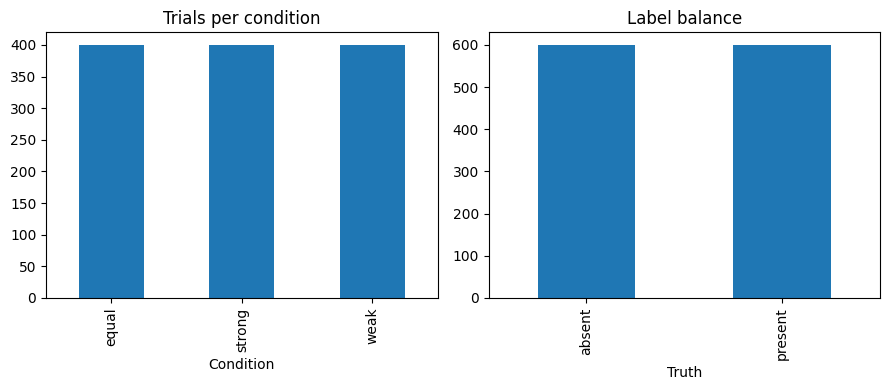

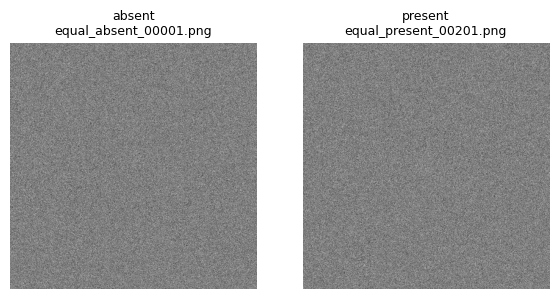

In [35]:
# %%
# 1) Quick distribution plots
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
df_trials["Condition"].value_counts().sort_index().plot(kind="bar", ax=axes[0], title="Trials per condition")
(df_trials["Truth"].map({0: "absent", 1: "present"})
 .value_counts()
 .reindex(["absent", "present"])
 .fillna(0)
).plot(kind="bar", ax=axes[1], title="Label balance")
plt.tight_layout(); plt.show()

# Pick one absent and one present example
absent_row  = df_trials[df_trials["Truth"] == 0].head(1)
present_row = df_trials[df_trials["Truth"] == 1].head(1)

sample_rows = pd.concat([absent_row, present_row])
sample_paths = sample_rows["Image"].astype(str).tolist()
labels = sample_rows["Truth"].map({0: "absent", 1: "present"}).tolist()

# Show them in grayscale
fig, axes = plt.subplots(1, len(sample_paths), figsize=(6,3))
if len(sample_paths) == 1:
    axes = [axes]

for ax, path, lab in zip(axes, sample_paths, labels):
    if Path(path).exists():
        im = Image.open(path).convert("L")
        ax.imshow(im, cmap="gray", vmin=0, vmax=255)
        ax.set_title(f"{lab}\n{Path(path).name}", fontsize=9)
    else:
        ax.text(0.5, 0.5, "Missing file", ha="center", va="center")
    ax.axis("off")

plt.tight_layout(); plt.show()

In [36]:
# %%
from time import time
from pathlib import Path

def run_llms(df: pd.DataFrame, limit: int | None = 50) -> pd.DataFrame:
    it = df if limit is None else df.head(limit)
    rows = []

    for _, r in tqdm(it.iterrows(), total=len(it), desc="LLM trials"):
        trial_id  = int(r["TrialID"])
        cond      = str(r["Condition"]).strip().lower()
        truth     = int(r["Truth"])
        img_path  = str(r["Image"])

        # quick file check
        if not Path(img_path).exists():
            rows.append({
                "TrialID": trial_id, "Condition": cond, "Truth": truth, "Image": img_path,
                "provider": "OpenAI", "model": OPENAI_MODEL,
                "raw": "ERROR: file not found", "decision": -1, "latency_s": -1, "correct": 0
            })
            rows.append({
                "TrialID": trial_id, "Condition": cond, "Truth": truth, "Image": img_path,
                "provider": "Gemini", "model": GEMINI_MODEL,
                "raw": "ERROR: file not found", "decision": -1, "latency_s": -1, "correct": 0
            })
            continue

        # --- OpenAI ---
        try:
            t0 = time()
            oai = call_openai(img_path, cond)   # must return {"raw": str, "decision": 0/1}
            t1 = time()
            rows.append({
                "TrialID": trial_id, "Condition": cond, "Truth": truth, "Image": img_path,
                "provider": "OpenAI", "model": OPENAI_MODEL,
                "raw": oai.get("raw",""), "decision": int(oai.get("decision",-1)),
                "latency_s": round(t1 - t0, 3),
                "correct": int(int(oai.get("decision",-1)) == truth) if oai.get("decision",-1) in (0,1) else 0,
            })
        except Exception as e:
            rows.append({
                "TrialID": trial_id, "Condition": cond, "Truth": truth, "Image": img_path,
                "provider": "OpenAI", "model": OPENAI_MODEL,
                "raw": f"ERROR: {e}", "decision": -1, "latency_s": -1, "correct": 0
            })

        # --- Gemini ---
        try:
            t1 = time()
            gmi = call_gemini(img_path, cond)   # must return {"raw": str, "decision": 0/1}
            t2 = time()
            rows.append({
                "TrialID": trial_id, "Condition": cond, "Truth": truth, "Image": img_path,
                "provider": "Gemini", "model": GEMINI_MODEL,
                "raw": gmi.get("raw",""), "decision": int(gmi.get("decision",-1)),
                "latency_s": round(t2 - t1, 3),
                "correct": int(int(gmi.get("decision",-1)) == truth) if gmi.get("decision",-1) in (0,1) else 0,
            })
        except Exception as e:
            rows.append({
                "TrialID": trial_id, "Condition": cond, "Truth": truth, "Image": img_path,
                "provider": "Gemini", "model": GEMINI_MODEL,
                "raw": f"ERROR: {e}", "decision": -1, "latency_s": -1, "correct": 0
            })

    return pd.DataFrame(rows)


# results = run_llms(df_trials, limit=24)
# results.to_csv(RESULTS_CSV, index=False)
# summarize(results)

In [37]:
# %%
def summarize(df: pd.DataFrame):
    """
    Expect columns:
      - provider (str)
      - Condition (str)
      - Truth (0/1)
      - decision (int in 1..10)  # confidence rating
    """
    if df is None or df.empty:
        print("[warn] no results"); 
        return

    df = df.copy()

    # Keep only valid confidence responses
    df["decision"] = pd.to_numeric(df["decision"], errors="coerce").astype("Int64")
    df = df[df["decision"].between(1, 10, inclusive="both")]

    if df.empty:
        print("[warn] no valid 1–10 decisions to summarize.")
        return

    # Map confidence → binary prediction (≤5 = absent, ≥6 = present)
    df["pred"] = (df["decision"] >= 6).astype(int)
    df["correct"] = (df["pred"] == df["Truth"]).astype(int)

    # ========== Tables ==========
    overall_acc = (
        df.groupby("provider")["correct"].mean().rename("accuracy").to_frame().reset_index()
    )
    by_cond_acc = (
        df.groupby(["provider", "Condition"])["correct"]
          .mean().rename("accuracy").to_frame().reset_index()
    )
    # Confidence summaries
    mean_conf = (
        df.groupby(["provider", "Truth"])["decision"]
          .mean().rename("mean_confidence").to_frame().reset_index()
          .replace({"Truth": {0: "absent", 1: "present"}})
    )

    print("Overall accuracy")
    display(overall_acc)

    print("\nAccuracy by condition")
    display(by_cond_acc)

    print("\nMean confidence by ground truth")
    display(mean_conf)

    # ========== Plots ==========
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # (1) Overall accuracy per provider
    axes[0].set_title("Overall accuracy")
    axes[0].bar(overall_acc["provider"], overall_acc["accuracy"])
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel("Accuracy")

    # (2) Accuracy by condition (grouped bars)
    pv_acc = by_cond_acc.pivot(index="Condition", columns="provider", values="accuracy").fillna(0)
    pv_acc.plot(kind="bar", ax=axes[1], title="Accuracy by condition", ylim=(0, 1))
    axes[1].set_xlabel("Condition")
    axes[1].set_ylabel("Accuracy")

    # (3) Mean confidence by truth (grouped bars)
    pv_conf = mean_conf.pivot(index="Truth", columns="provider", values="mean_confidence").reindex(["absent","present"])
    pv_conf.plot(kind="bar", ax=axes[2], title="Mean confidence by truth", ylim=(1, 10))
    axes[2].set_xlabel("Ground truth")
    axes[2].set_ylabel("Mean confidence (1–10)")

    plt.tight_layout()
    plt.show()

#summarize(results)


In [38]:
# %%
# Uncomment to run all trials
# results_full = run_llms(df_trials, limit=None)
# results_full.to_csv(RESULTS_CSV, index=False)
# summarize(results_full)
